# Podcast Recommender System 

## Import Packages

In [6]:
#Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse import hstack

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 70)

## Podcast Dataset

### Data Import and Exploratory Data Analysis

In [16]:
podcasts = pd.read_csv(r"C:\Users\abhin\Downloads\podcast_recommendation\podcasts.csv")

In [17]:
podcasts.shape

(121175, 9)

In [18]:
podcasts.head(5)

,uuid,title,image,description,language,categories,website,author,itunes_id
0,8d62d3880db2425b890b986e58aca393,"Ecommerce Conversations, by Practical Ecommerce",http://is4.mzstatic.com/image/thumb/Music6/v4/...,Listen in as the Practical Ecommerce editorial...,English,Technology,http://www.practicalecommerce.com,Practical Ecommerce,874457373
1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393
2,73626ad1edb74dbb8112cd159bda86cf,SoundtrackAlley,http://is5.mzstatic.com/image/thumb/Music71/v4...,A podcast about soundtracks and movies from my...,English,Podcasting | Technology,https://soundtrackalley.podbean.com,Randy Andrews,1158188937
3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025
4,69580e7b419045839ca07af06cf0d653,"The Tech Informist - For fans of Apple, Google...",http://is4.mzstatic.com/image/thumb/Music62/v4...,The tech news show with two guys shooting the ...,English,Gadgets | Tech News | Technology,http://techinformist.com,The Tech Informist,916080498


#### Languages in Podcast Dataset

<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='language'>

Text(0.5, 1.0, 'Podcasts by Language')

Text(0.5, 0, 'Languages')

Text(0, 0.5, 'Number of Podcasts')

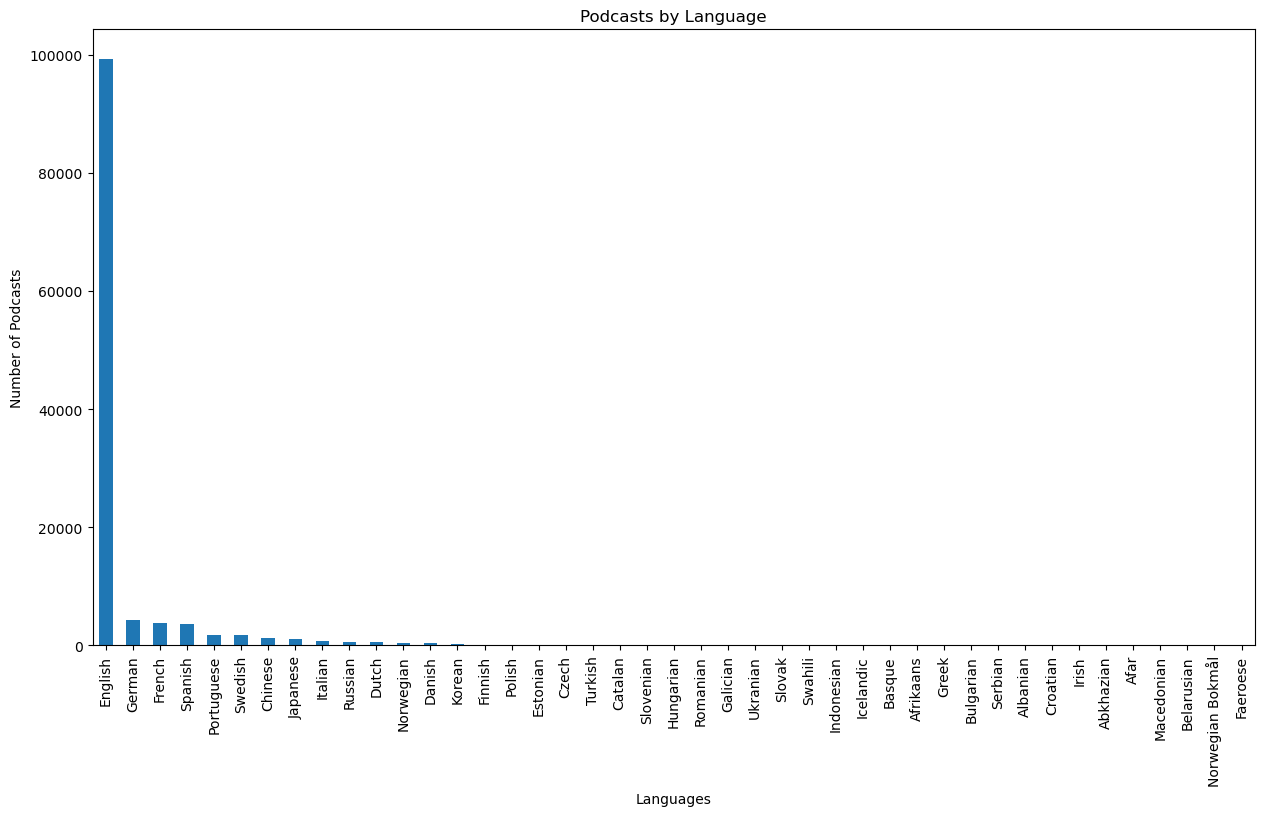

In [21]:
plt.figure(figsize=(15,8))
podcasts['language'].value_counts().plot.bar()
plt.title('Podcasts by Language')
plt.xlabel('Languages')
plt.ylabel('Number of Podcasts')
plt.show()

In [85]:
pip install nbconvert

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='categories'>

Text(0.5, 1.0, 'Top 25 Most Frequent Podcasts Categories')

Text(0.5, 0, 'Categories')

Text(0, 0.5, 'Number of Podcasts')

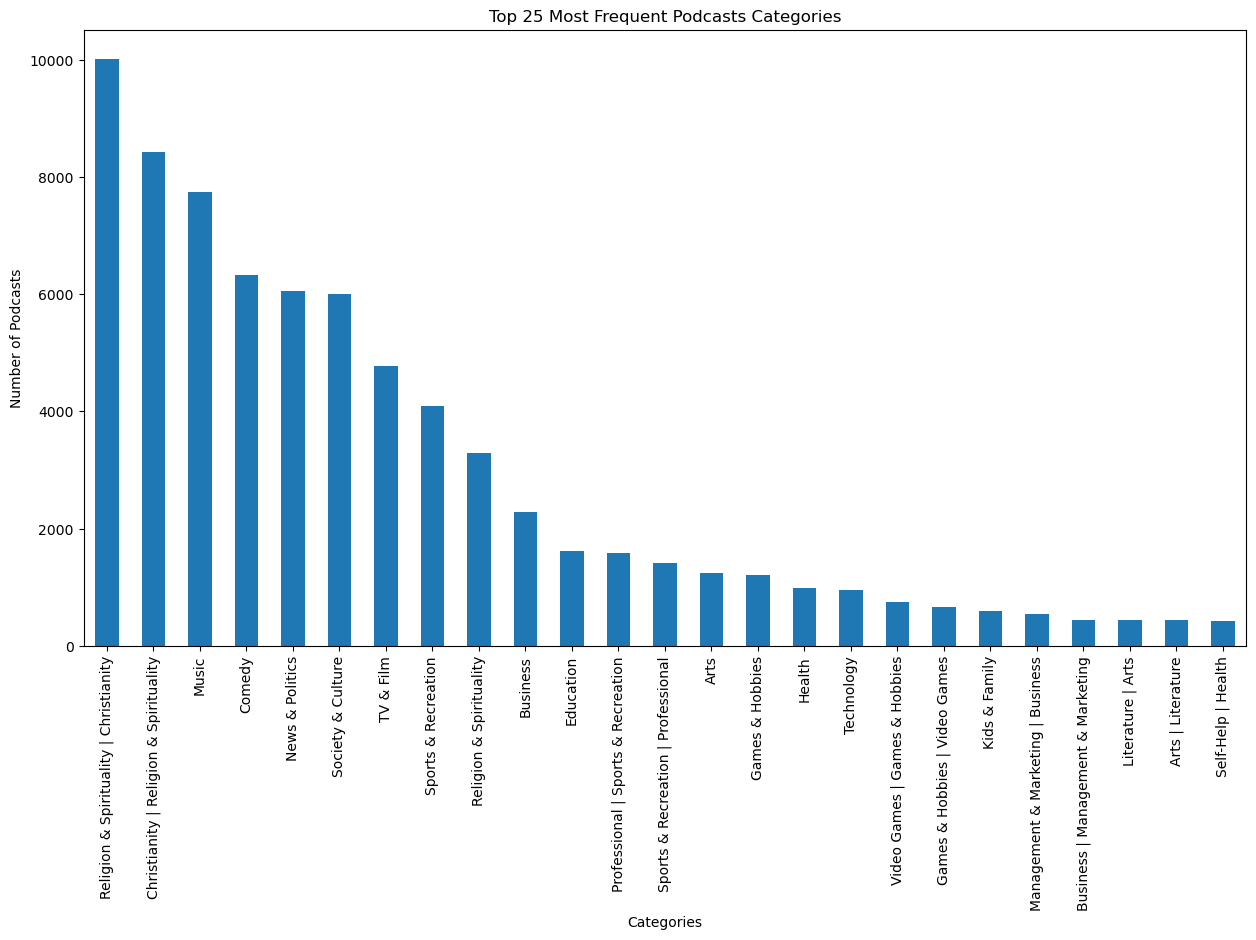

In [22]:
plt.figure(figsize=(15,8))
podcasts['categories'].value_counts()[:25].plot.bar()
plt.title('Top 25 Most Frequent Podcasts Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Podcasts');
plt.show()

#### Filter english podcast

In [23]:
podcasts = podcasts[podcasts.language == 'English']

#### Removing podcast with missing descriptions and duplicate ids

In [24]:
podcasts = podcasts.dropna(subset=['description'])
podcasts = podcasts.drop_duplicates('itunes_id')

In [25]:
podcasts.description.isnull().sum()

0

#### Removing podcast descriptions lesser than 20 words 

In [62]:
podcasts['description_length'] = [len(x.description.split()) for _, x in podcasts.iterrows()]

In [63]:
podcasts['description_length'].describe()

count    59322.000000
mean        58.265905
std        134.333135
min         20.000000
25%         30.000000
50%         44.000000
75%         68.000000
max      30157.000000
Name: description_length, dtype: float64

In [64]:
podcasts = podcasts[podcasts.description_length >= 20]

## Building Recommendation Engine 

### Constructing categories matrix 

#### Tokenizing and dummifying categories to form a categories matrix 

In [65]:
podcasts.shape

(59322, 11)

In [66]:
podcasts.categories.fillna('None', inplace=True)

C:\Users\abhin\AppData\Local\Temp\ipykernel_39892\1503437268.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  podcasts.categories.fillna('None', inplace=True)


In [67]:
unique_podcast_categories = podcasts.categories.unique()

In [68]:
final_podcast_categories = set()
for category in unique_podcast_categories: 
    strip_cats = [cat_split.strip() for cat_split in category.split('|')]
    for strip_cat in strip_cats:
        final_podcast_categories.add(strip_cat)
new_features = list(final_podcast_categories)

In [69]:
# converting list into columns and then appending it to podcast dataframe 
podcast_category_df = pd.DataFrame()
# a loop that checks if categories column has the word in each of the new columns 1 for yes 0 for no
for column_name in new_features:
    boolean_series = podcasts.categories.str.contains(column_name).astype(int)
    podcast_category_df[column_name] = boolean_series

In [70]:
podcast_category_df.shape

(59322, 67)

In [71]:
podcast_category_df.head()

,Gadgets,College & High School,Games & Hobbies,TV & Film,Natural Sciences,Design,Amateur,Christianity,Judaism,Kids & Family,Shopping,Spirituality,Automotive,Health,Islam,Society & Culture,Places & Travel,Higher Education,Visual Arts,Philosophy,News & Politics,Non-Profit,Management & Marketing,Sexuality,Education,Comedy,Business,Regional,Self-Help,Other,K-12,Software How-To,Hobbies,Sports & Recreation,Careers,Performing Arts,Science & Medicine,Podcasting,Food,Fashion & Beauty,Business News,Language Courses,Religion & Spirituality,National,Tech News,Literature,Buddhism,Social Sciences,Video Games,History,Other Games,Educational Technology,Investing,Alternative Health,Local,Professional,Training,Medicine,Aviation,Government & Organizations,Outdoor,Fitness & Nutrition,Personal Journals,Music,Hinduism,Technology,Arts
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [72]:
podcast_category_df = podcast_category_df / 125

### Generate Recommendations

In [73]:
podcasts['description'] = podcasts['description'].astype(str)

In [74]:
podcasts.shape

(59322, 11)

In [75]:
podcasts = podcasts.reset_index()

In [76]:
podcasts.head(3)

,level_0,index,uuid,title,image,description,language,categories,website,author,itunes_id,description_length
0,0,1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393,59
1,1,3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025,59
2,2,7,f4d85755dd6048978f27681ed59a20fe,"Social Media, Mobility, Analytics, Cloud: Tech...",http://is2.mzstatic.com/image/thumb/Music118/v...,SMACtalk hosted by Brian Fanzo and Daniel Newm...,English,Management & Marketing | Business | Technology...,http://smactalklive.live,Brian Fanzo & Daniel Newman,953547333,52


#### Testing TF-IDF 

In [35]:
%%time
 tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
tf_idf = tf.fit_transform(podcasts['description'])
tf_idf

CPU times: total: 4.62 s
Wall time: 4.77 s


<59322x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1428214 stored elements in Compressed Sparse Row format>

#### Testing CountVectorizer

In [77]:

%%time

# play around with the max_features to see which gives better recommendations 

cvec = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
cvec = cvec.fit_transform(podcasts['description'])


CPU times: total: 6.08 s
Wall time: 6.37 s


### Creating sparse matrix

#### Appending vectorized sparse matrix with categories matrix

In [80]:
category_array = podcast_category_df.to_numpy()
sparse_category = sparse.csr_matrix(category_array)
sparse_category.shape

(59322, 67)

In [38]:
tf_idf = hstack([tf_idf, sparse_category])

In [81]:
cvec = hstack([cvec, sparse_category])

In [40]:
%%time 
similarity_matrix_t = cosine_similarity(tf_idf, dense_output=False)

CPU times: total: 23 s
Wall time: 23.9 s


In [82]:
%%time 
similarity_matrix_c = cosine_similarity(cvec, dense_output=False)
print('done')

done
CPU times: total: 25.9 s
Wall time: 34 s


In [41]:
similarity_matrix_t.shape

(59322, 59322)

In [83]:
similarity_matrix_c.shape

(59322, 59322)

### Testing recommendation with top 5

####  Recommendations from TFIDF Vectorize

In [45]:
x = podcasts[podcasts.title == '99% Invisible'].index[0]
podcast_similarities = similarity_matrix_t[x].todense()
similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
for i in range(4,-1,-1):
    print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts.title[similar_idx.item(i)], '-', podcasts.description[similar_idx.item(i)], '\n')
print('Original - ' + podcasts.title[x] + ' -' + podcasts.description[x])

0.6591785211043745 - Radio Diaries - 
      First-person diaries, sound portraits, and hidden chapters of history from Peabody Award-winning producer Joe Richman and the Radio Diaries team. From teenagers to octogenarians, prisoners to prison guards, bra saleswomen to lighthouse keepers. The extraordinary stories of ordinary life.  <a href="http://www.radiodiaries.org">Radio Diaries</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.6548793139878243 - Benjamen Walker's Theory of Everything - 
      Personally connecting the dots. All of them.  <a href="http://toe.prx.org">Benjamen Walker's Theory of Everything</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.592114475793706 - The Heart - <a href="http://www.theheartradio.org">The Heart</a> is an audio art project about intimacy and humanity. A proud member of <a href="http://radiotopia.fm/">Radio

####  Recommendations from CountVectorize

In [84]:
x = podcasts[podcasts.title == '99% Invisible'].index[0]
''''.todense() method then unpacks each podcasts similarity matrix one at a time returning a 1x59322 matrix containing the similarity coefficients
of the referenced podcast against all 59,322 other podcasts. This avoids kernel crash.'''
podcast_similarities = similarity_matrix_c[x].todense()
similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
for i in range(4,-1,-1):
    print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts.title[similar_idx.item(i)], '-', podcasts.description[similar_idx.item(i)], '\n')
print('Original - ' + podcasts.title[x] + ' -' + podcasts.description[x])

"'.todense() method then unpacks each podcasts similarity matrix one at a time returning a 1x59322 matrix containing the similarity coefficients\nof the referenced podcast against all 59,322 other podcasts. This avoids kernel crash."

0.6694359441465274 - Benjamen Walker's Theory of Everything - 
      Personally connecting the dots. All of them.  <a href="http://toe.prx.org">Benjamen Walker's Theory of Everything</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.6128240249379643 - Radio Diaries - 
      First-person diaries, sound portraits, and hidden chapters of history from Peabody Award-winning producer Joe Richman and the Radio Diaries team. From teenagers to octogenarians, prisoners to prison guards, bra saleswomen to lighthouse keepers. The extraordinary stories of ordinary life.  <a href="http://www.radiodiaries.org">Radio Diaries</a> is a proud member of Radiotopia, from PRX. Learn more at <a href="http://radiotopia.fm/">radiotopia.fm</a>.
     

0.5477203179380679 - The Heart - <a href="http://www.theheartradio.org">The Heart</a> is an audio art project about intimacy and humanity. A proud member of <a href="http://radiotopia.fm/">Radi

As CountVectorizer suggesting slightly stronger similarities scores between the referenced podcast and the recommendation, CountVectorizer was used over TFIDFVectorizer.

## Generating Recommendations Database

This function pre-generates a recommendations database and allows user to pull recommendations for a podcast from the saved database. 

#### Solving an index 0 is out of bounds for axis 0 with size 0

In [47]:
podcasts.iloc[28001]

index                                                             57234
uuid                                   d67c6effe2214f30ada75d3351834cd4
title                                                               NaN
image                 http://is1.mzstatic.com/image/thumb/Music111/v...
description           Nole, Chris, and Terrence sit around a few mic...
language                                                        English
categories            Video Games | Games & Hobbies | Society & Culture
website                                  https://napodcast.fireside.fm/
author                                                              PPN
itunes_id                                                    1224670344
description_length                                                   23
Name: 28001, dtype: object

In [48]:
podcasts.title.iloc[28001] = 'NAN'

C:\Users\abhin\AppData\Local\Temp\ipykernel_11224\1324453514.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  podcasts.title.iloc[28001] = 'NAN'
C:\Users\abhin\AppData\Local\Temp\ipykernel_11224\1324453514.py:1: SettingWithCopyWarning: 
A

In [49]:
podcasts.iloc[28001]

index                                                             57234
uuid                                   d67c6effe2214f30ada75d3351834cd4
title                                                               NAN
image                 http://is1.mzstatic.com/image/thumb/Music111/v...
description           Nole, Chris, and Terrence sit around a few mic...
language                                                        English
categories            Video Games | Games & Hobbies | Society & Culture
website                                  https://napodcast.fireside.fm/
author                                                              PPN
itunes_id                                                    1224670344
description_length                                                   23
Name: 28001, dtype: object

This below step requires higher RAM configuration (32GB) to run successfully.

In [64]:
%%time
rec_db = {}
for podcast in podcasts.title:
    # unpacks information on respective podcast and saves info into a dictionary
    ref_podcast = podcasts[podcasts.title == podcast].index[0] 
    x = ref_podcast
    podcast_similarities = similarity_matrix_c[x].todense()
    similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
    rec_db[podcast] = podcasts.title[similar_idx.tolist()[0]].tolist()
    
# Convert dictionary to DataFrame
rec_db = pd.DataFrame.from_dict(rec_db, orient='index', columns=["first_rec", "second_rec", "third_rec", "fourth_rec", "fifth_rec"])

# Add a column for the reference podcast
rec_db = rec_db.reset_index().rename(columns={"index": "ref_podcast"})

# Save to CSV
rec_db.to_csv(r"C:\Users\abhin\Downloads\podcast_recommendation\recommendations_database_cvec.csv", index=False)
print("done")
rec_db.head()

done
CPU times: total: 8min 26s
Wall time: 10min 30s


,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
0,Eat Sleep Code Podcast,Stackify Developer Things,The freeCodeCamp Podcast,Oracle Developer Podcast,Storage Developer Conference,Complete Developer Podcast
1,The Tech M&A Podcast,Technocrats (Audio),Tech Reformation,Ado Veli Podcast,Speaking in Tech,The TechBox
2,"Social Media, Mobility, Analytics, Cloud: Tech...",Two Cracked Pots,The Communicators,Lanced Podcast,Technology Wizard,The Cloudcast (.net) - Weekly Cloud Computing ...
3,Radio Leo (Video LO),Aggregate Feed - LoadingReadyRun,Melted Chocolate Master Feed,Radio Leo (Video LO),Radio Leo (Video HD),Radio Leo (MP3)
4,Digital India,AMPUP Your Digital Marketing,Social Media Talks Podcast Kompass Media,The Science of Social Media,VADEMECUM BLOGERA,The EchoJunction Podcast with Adam Fraser


In [65]:
podcasts.to_csv(r"C:\Users\abhin\Downloads\podcast_recommendation\podcast_data_cleaned.csv", index=False)
print("done")

done


### LookUp function for podcast recommendations

In [21]:
df = pd.read_csv(r"C:\Users\abhin\Downloads\podcast_recommendation\recommendations_database_cvec.csv")
df.head()

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
0,Eat Sleep Code Podcast,Stackify Developer Things,The freeCodeCamp Podcast,Oracle Developer Podcast,Storage Developer Conference,Complete Developer Podcast
1,The Tech M&A Podcast,Technocrats (Audio),Tech Reformation,Ado Veli Podcast,Speaking in Tech,The TechBox
2,"Social Media, Mobility, Analytics, Cloud: Tech...",Two Cracked Pots,The Communicators,Lanced Podcast,Technology Wizard,The Cloudcast (.net) - Weekly Cloud Computing ...
3,Radio Leo (Video LO),Aggregate Feed - LoadingReadyRun,Melted Chocolate Master Feed,Radio Leo (Video LO),Radio Leo (Video HD),Radio Leo (MP3)
4,Digital India,AMPUP Your Digital Marketing,Social Media Talks Podcast Kompass Media,The Science of Social Media,VADEMECUM BLOGERA,The EchoJunction Podcast with Adam Fraser


In [22]:
df = df.rename(columns={"Unnamed: 0": "ref_podcast", 
                   "0": "first_rec",
                   "1": "second_rec",
                   "2": "third_rec",
                   "3": "fourth_rec",
                   "4": "fifth_rec"})

df.head()

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
0,Eat Sleep Code Podcast,Stackify Developer Things,The freeCodeCamp Podcast,Oracle Developer Podcast,Storage Developer Conference,Complete Developer Podcast
1,The Tech M&A Podcast,Technocrats (Audio),Tech Reformation,Ado Veli Podcast,Speaking in Tech,The TechBox
2,"Social Media, Mobility, Analytics, Cloud: Tech...",Two Cracked Pots,The Communicators,Lanced Podcast,Technology Wizard,The Cloudcast (.net) - Weekly Cloud Computing ...
3,Radio Leo (Video LO),Aggregate Feed - LoadingReadyRun,Melted Chocolate Master Feed,Radio Leo (Video LO),Radio Leo (Video HD),Radio Leo (MP3)
4,Digital India,AMPUP Your Digital Marketing,Social Media Talks Podcast Kompass Media,The Science of Social Media,VADEMECUM BLOGERA,The EchoJunction Podcast with Adam Fraser


In [43]:
df.head()

,index,uuid,title,image,description,language,categories,website,author,itunes_id,description_length
0,1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393,59
1,3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025,59
2,7,f4d85755dd6048978f27681ed59a20fe,"Social Media, Mobility, Analytics, Cloud: Tech...",http://is2.mzstatic.com/image/thumb/Music118/v...,SMACtalk hosted by Brian Fanzo and Daniel Newm...,English,Management & Marketing | Business | Technology...,http://smactalklive.live,Brian Fanzo & Daniel Newman,953547333,52
3,8,7b131a464c4b4f34a8f62de738417fc4,Radio Leo (Video LO),http://is4.mzstatic.com/image/thumb/Music71/v4...,"A compendium of netcasts from the Chief TWiT, ...",English,Tech News | Technology | News & Politics | Gad...,https://twit.tv/shows/radio-leo,Leo Laporte,808313192,34
4,9,7bbb6386cacb45518f2e5b2427c4cbb1,Digital India,http://is4.mzstatic.com/image/thumb/Music60/v4...,"Suresh Babu, founder and head of the Web Marke...",English,Podcasting | Management & Marketing | Tech New...,https://firpodcastnetwork.com/digital-india/,Digital India,1003892435,29


In [23]:
def recommendation_lookup(rec_db, podcast_title):
    return rec_db[rec_db['ref_podcast'] == podcast_title]

In [24]:
recommendation_lookup(df, '99% Invisible')

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
25725,99% Invisible,Strangers,The Mortified Podcast,The Heart,Radio Diaries,Benjamen Walker's Theory of Everything


In [25]:
recommendation_lookup(df, 'Digital India')

,ref_podcast,first_rec,second_rec,third_rec,fourth_rec,fifth_rec
4,Digital India,AMPUP Your Digital Marketing,Social Media Talks Podcast Kompass Media,The Science of Social Media,VADEMECUM BLOGERA,The EchoJunction Podcast with Adam Fraser


## Generating recommendations on unseen data

**NOTE**: Reset kernel before proceeding.

This function generates a recommendation based on what user has entered and returns recommendations. 

In [41]:
import pandas as pd
podcasts_z = pd.read_csv(r"C:\Users\abhin\Downloads\podcast_recommendation\podcast_data_cleaned.csv")
print("done")

done


In [42]:
podcasts_z.shape

(59322, 11)

In [43]:
podcasts_z.isnull().sum()

index                   0
uuid                    0
title                   0
image                   0
description             0
language                0
categories              0
website               607
author                722
itunes_id               0
description_length      0
dtype: int64

In [4]:
# PROCESS 
# search for podcast in database, if it doesn't appear in the search bar,
# try other option 'Recommend based on Unseen Data'
# I.E: enter your podcast title, short description (preferably 20 words, can be just key words) and the one of these categories (drop down menu)

# possible bug, what if the person enters an existing podcast into the alternative option? case sensitive or not,
# stops the person from entering an existing podcast. [something like that~~]
new_podcast_title = 'Wait, Hold Up!' 
new_podcast_description = 'Each week, tune in as Yarel and Jessica interview people you know (or who they think you should know) who are on their grind and learn the ''wait, hold up'' moments that changed their lives. When they''re not with a guest they''re diving into the latest in pop culture & politics.'
new_podcast_categories = 'Society & Culture | Self-Help'

In [45]:
podcasts.head()
podcasts_z = podcasts.drop(['index','uuid','image','language','website','author','itunes_id', 'description_length'], axis=1)

,index,uuid,title,image,description,language,categories,website,author,itunes_id,description_length
0,1,cbbefd691915468c90f87ab2f00473f9,Eat Sleep Code Podcast,http://is4.mzstatic.com/image/thumb/Music71/v4...,On the show we’ll be talking to passionate peo...,English,Tech News | Technology,http://developer.telerik.com/,Telerik,1015556393,59
1,3,0f50631ebad24cedb2fee80950f37a1a,The Tech M&A Podcast,http://is1.mzstatic.com/image/thumb/Music71/v4...,The Tech M&A Podcast pulls from the best of th...,English,Business News | Technology | Tech News | Business,http://www.corumgroup.com,Timothy Goddard,538160025,59
2,7,f4d85755dd6048978f27681ed59a20fe,"Social Media, Mobility, Analytics, Cloud: Tech...",http://is2.mzstatic.com/image/thumb/Music118/v...,SMACtalk hosted by Brian Fanzo and Daniel Newm...,English,Management & Marketing | Business | Technology...,http://smactalklive.live,Brian Fanzo & Daniel Newman,953547333,52
3,8,7b131a464c4b4f34a8f62de738417fc4,Radio Leo (Video LO),http://is4.mzstatic.com/image/thumb/Music71/v4...,"A compendium of netcasts from the Chief TWiT, ...",English,Tech News | Technology | News & Politics | Gad...,https://twit.tv/shows/radio-leo,Leo Laporte,808313192,34
4,9,7bbb6386cacb45518f2e5b2427c4cbb1,Digital India,http://is4.mzstatic.com/image/thumb/Music60/v4...,"Suresh Babu, founder and head of the Web Marke...",English,Podcasting | Management & Marketing | Tech New...,https://firpodcastnetwork.com/digital-india/,Digital India,1003892435,29


In [46]:
# unseen podcast title, description and category entered into the dataframe
def update_new_podcast(podcasts_df, new_podcast_title, new_podcast_description, new_podcast_categories):
    new_podcast_row = pd.DataFrame(np.array([[new_podcast_title, new_podcast_description, new_podcast_categories]]), columns=['title', 'description','categories'])
    podcasts_df = pd.concat([new_podcast_row, podcasts_z], ignore_index=True)
    
    return podcasts_df

In [47]:
podcasts_z = update_new_podcast(podcasts_z, new_podcast_title, new_podcast_description, new_podcast_categories)

In [48]:
podcasts_z

,title,description,categories
0,"Wait, Hold Up!","Each week, tune in as Yarel and Jessica interv...",Society & Culture | Self-Help
1,Eat Sleep Code Podcast,On the show we’ll be talking to passionate peo...,Tech News | Technology
2,The Tech M&A Podcast,The Tech M&A Podcast pulls from the best of th...,Business News | Technology | Tech News | Business
3,"Social Media, Mobility, Analytics, Cloud: Tech...",SMACtalk hosted by Brian Fanzo and Daniel Newm...,Management & Marketing | Business | Technology...
4,Radio Leo (Video LO),"A compendium of netcasts from the Chief TWiT, ...",Tech News | Technology | News & Politics | Gad...
...,...,...,...
59318,Stereo Embers: The Podcast,"Hosted by Alex Green, Stereo Embers: The Podca...",Music
59319,For Your Benefit,Host Bob Leins and presenters from the Nationa...,Government & Organizations | News & Politics |...
59320,BAFTA Guru,BAFTA is a world-leading independent arts char...,TV & Film
59321,The Junction,The best mix old of school and new school hip ...,Arts | TV & Film | Music


In [49]:
# updating the category matrix with unseen podcast category
def update_category_matrix(podcasts_df):
    # convert list into columns and append to podcast dataframe 
    category_df = pd.DataFrame()
    # run a loop to check if categories column has the word in each of the new columns 1 for yes 0 for no
    for column_name in new_features:
        boolean_series = podcasts_df.categories.str.contains(column_name).astype(float)
        category_df[column_name] = boolean_series
    return category_df / 125
    

In [50]:
category_df = update_category_matrix(podcasts_z)

In [51]:
# appended to the original podcast dataset and generate predictions as per usual. 
def podcast_recommendor_sparse(podcasts_df, new_podcast_title, category_df):
        podcasts_df['description'] = podcasts_df['description'].astype(str)

        # vectorize podcast descriptions 
        tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), max_features = 5000, stop_words = "english")
        tf_idf = tf.fit_transform(podcasts_df['description'])
        
        #append sparse category matrix
        category_array = category_df.to_numpy()
        sparse_category = sparse.csr_matrix(category_array)
        tf_idf = hstack([tf_idf, sparse_category])
        return tf_idf

In [52]:
tf_idf = podcast_recommendor_sparse(podcasts_z, new_podcast_title, category_df)

In [53]:
def podcast_recommender_new(podcasts_df, new_podcast_title, tf_idf=tf_idf):
        # generates similarity matrix
        similarity_matrix = cosine_similarity(tf_idf, dense_output=False)  
        # unpacks information on respective podcast 
        x = podcasts_df[podcasts_df.title == new_podcast_title].index[0]
        podcast_similarities = similarity_matrix[x].todense()
        similar_idx = podcast_similarities.argsort(axis=None)[:,-6:-1]
        for i in range(4,-1,-1):
            print(podcast_similarities.item(similar_idx.item(i)), '-', podcasts_df.title[similar_idx.item(i)], '-', podcasts_df.description[similar_idx.item(i)], '\n')
        print('Original - ' + podcasts_df.title[x] + ' -' + podcasts_df.description[x])

In [54]:
podcast_recommender_new(podcasts_z, new_podcast_title, tf_idf=tf_idf)

0.2858539172722759 - Drinking Buddies Podcast - A podcast about everything from pop culture to politics to sports. Two friends that have a couple beers and discuss the past week. 

0.2786600750403002 - Danger! Talks... - An open discussion podcast on subjects that I want to know more about with the people that know more about them. 

0.264942052241013 - Olympia Pop Rocks - Guire and Jemmy Joe interview local Olympians of note, and discuss pop culture, politics, local issues or whatever strikes their fancy. 

0.2580537547340273 - People I Know - People I Know - the podcast that talks to interesting people so you don't have to. Each episode will see a new interesting person that I know, talk about some interesting people that they know... not forgetting the all-important scented candle review! 

0.2543629237085361 - The Raven Effect - Join professional wrestling superstar & world class idiot, Raven, along with a motley assortment of friends, enemies, know-it-alls, know nothings, professi